In [97]:
pip install pandas dask duckdb xgboost scikit-learn shap matplotlib seaborn boto3

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Install the necessary Dask package
!pip install dask[dataframe] --quiet

# Import necessary libraries
import glob
import dask.dataframe as dd
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import shap
import boto3
import json
import os
from dask import delayed
import numpy as np
import datetime
from sklearn.metrics import accuracy_score, classification_report

# Setting display options for better visualization
pd.set_option('display.max_columns', None)

In [2]:
# Specify the directory containing the dataset
data_dir = (r"C:\Users\navee\Music\BITS-Pilani , M-Tech , Sem-4\Bits Final Project\Final Project\Neo Bank Churn datafiles")  # Replace with the path to your dataset folder

# Step 1: Using Glob to collect train and test Parquet files
train_files = glob.glob(os.path.join(data_dir, "train_*.parquet"))  # Train files (2008 to 2023)
test_files = glob.glob(os.path.join(data_dir, "test.parquet"))  # Test file

print(f"Found {len(train_files)} train files and {len(test_files)} test files.")  # Printing no. of train & test files loaded .

# Step 2: Load train data using Dask for scalability
train_dask_df = dd.read_parquet(train_files)

# Display the first few rows of the train data
print("Train Data Preview:")
print(train_dask_df.head())


Found 16 train files and 1 test files.
Train Data Preview:
   Id  customer_id  interest_rate            name    country date_of_birth  \
0   1            1            3.5  Yolanda Parker  Lithuania    1954-07-10   
1   6            1            3.5  Yolanda Parker  Lithuania    1954-07-10   
2  16            1            3.5  Yolanda Parker  Lithuania    1954-07-10   
3  31            1            3.5  Yolanda Parker  Lithuania    1954-07-10   
4  50            1            3.5  Yolanda Parker  Lithuania    1954-07-10   

                                             address       date  \
0  1929 Erin Lights Suite 709
Lake Michaelburgh, ... 2008-01-17   
1  1929 Erin Lights Suite 709
Lake Michaelburgh, ... 2008-01-18   
2  1929 Erin Lights Suite 709
Lake Michaelburgh, ... 2008-01-19   
3  1929 Erin Lights Suite 709
Lake Michaelburgh, ... 2008-01-20   
4  1929 Erin Lights Suite 709
Lake Michaelburgh, ... 2008-01-21   

   atm_transfer_in  atm_transfer_out  bank_transfer_in  bank_transfer

In [3]:
# Step 3: Load test data using Dask
test_dask_df = dd.read_parquet(test_files)

# Display the first few rows of the test data
print("Test Data Preview:")
print(test_dask_df.head())

Test Data Preview:
        Id  customer_id  interest_rate                name         country  \
0  6187320        68714            3.0   Shannon Rodriguez         Belgium   
1  6187321        90102            3.0  Michael Hutchinson  Czech Republic   
2  6187322       106090            3.0        Lisa Johnson       Lithuania   
3  6187323        90092            3.0    Kimberly Bennett         Austria   
4  6187324        90083            3.0    Holly Perkins MD         Belgium   

  date_of_birth                                            address       date  \
0    1988-02-03  68295 Young Cliff Suite 989
Wilsonland, NC 465... 2024-01-01   
1    1968-08-01            USCGC Knapp
FPO AA 87355 Czech Republic 2024-01-01   
2    1970-04-10  1768 Timothy Common
South Kyleborough, SD 8724... 2024-01-01   
3    1942-11-28  7518 David River
West Stevenborough, AL 26963 ... 2024-01-01   
4    1971-09-11  6667 Laura Motorway Apt. 513
Ortizhaven, PA 47... 2024-01-01   

   atm_transfer_in  atm_t

In [4]:
# Step 4: Load the sample submission file
sample_submission_path = os.path.join(data_dir, "sample_submission.csv")
sample_submission_df = pd.read_csv(sample_submission_path)

# Display the sample submission format
print("Sample Submission Format:")
print(sample_submission_df.head())

Sample Submission Format:
        Id  churn
0  6187320    0.5
1  6187321    0.5
2  6187322    0.5
3  6187323    0.5
4  6187324    0.5


In [5]:
# Create the transaction amount feature as a proxy in train dataset
train_dask_df['transaction_amount'] = (
    train_dask_df['bank_transfer_in_volume'] +
    train_dask_df['bank_transfer_out_volume'] +
    train_dask_df['crypto_in_volume'] +
    train_dask_df['crypto_out_volume']
)


# Create the transaction amount feature as a proxy in test dataset
test_dask_df['transaction_amount'] = (
    test_dask_df['bank_transfer_in_volume'] +
    test_dask_df['bank_transfer_out_volume'] +
    test_dask_df['crypto_in_volume'] +
    test_dask_df['crypto_out_volume']
)

In [6]:
# Convert Dask DataFrame to a Pandas DataFrame
pandas_train_df = train_dask_df.compute()
pandas_test_df = test_dask_df.compute()

In [7]:
# Connect to DuckDB
con = duckdb.connect()

# Create a DuckDB table from the Pandas DataFrame for SQL querying
con.execute("CREATE TABLE bank_data AS SELECT * FROM pandas_train_df")

In [10]:
# Check unique values in the churn column of train dataset
churn_counts_train = pandas_train_df['churn_due_to_fraud'].value_counts() 
print("Churn Counts in train:\n", churn_counts_train)  # Print churn counts

# Check unique values in the churn column of test dataset
churn_counts_test = pandas_test_df['churn_due_to_fraud'].value_counts()  
print("\nChurn Counts in test:\n", churn_counts_test)  # Print churn counts

Churn Counts in train:
 churn_due_to_fraud
False    3926031
True          27
Name: count, dtype: int64

Churn Counts in test:
 churn_due_to_fraud
False    1360417
True          55
Name: count, dtype: int64


In [11]:
pandas_train_df.head()

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud,transaction_amount
0,1,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709 Lake Michaelburgh, ...",2008-01-17,0,0,17476,3911,56,13,7380.083338,5844.193394,393.145010,220.900654,0,[],"{'appointment': None, 'email': None, 'phone': ...",0,False,Amenity horticulturist,False,False,13838.322396
1,6,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709 Lake Michaelburgh, ...",2008-01-18,0,0,19680,3358,46,14,7504.751064,4986.370246,390.005729,221.147296,0,[],"{'appointment': None, 'email': None, 'phone': ...",1,False,Amenity horticulturist,False,False,13102.274335
2,16,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709 Lake Michaelburgh, ...",2008-01-19,0,0,17958,4113,48,13,6720.934090,7451.373471,393.209108,260.510535,0,[],"{'appointment': None, 'email': None, 'phone': ...",2,False,Amenity horticulturist,False,False,14826.027204
3,31,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709 Lake Michaelburgh, ...",2008-01-20,0,0,22772,3750,49,15,6976.218992,6548.352211,394.078294,203.214128,0,[],"{'appointment': None, 'email': None, 'phone': ...",3,False,Amenity horticulturist,False,False,14121.863625
4,50,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709 Lake Michaelburgh, ...",2008-01-21,0,0,23610,4005,60,12,6453.651629,6129.342716,395.174604,207.894467,0,"[whatsapp, email, email]","{'appointment': None, 'email': None, 'phone': ...",4,False,Amenity horticulturist,False,False,13186.063417


In [12]:
pandas_test_df.head()

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,crypto_in,crypto_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in_volume,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,Usage,model_predicted_fraud,transaction_amount
0,6187320,68714,3.0,Shannon Rodriguez,Belgium,1988-02-03,"68295 Young Cliff Suite 989 Wilsonland, NC 465...",2024-01-01,0,0,532,2,1,1,894.155487,149.683689,60.742249,20.922171,0,"[whatsapp, whatsapp, whatsapp]","{'appointment': None, 'email': None, 'phone': ...",1122,False,"Psychologist, educational",False,Private,False,1125.503595
1,6187321,90102,3.0,Michael Hutchinson,Czech Republic,1968-08-01,USCGC Knapp FPO AA 87355 Czech Republic,2024-01-01,0,0,2,5,1,1,1301.200834,24.784818,5.206756,1.802211,0,[],"{'appointment': None, 'email': None, 'phone': ...",399,False,Forensic psychologist,False,Private,False,1332.994619
2,6187322,106090,3.0,Lisa Johnson,Lithuania,1970-04-10,"1768 Timothy Common South Kyleborough, SD 8724...",2024-01-01,0,0,5,2,6,5,22.109319,11.548979,42.810827,11.712590,0,[],"{'appointment': None, 'email': None, 'phone': ...",3,False,General practice doctor,False,Private,False,88.181714
3,6187323,90092,3.0,Kimberly Bennett,Austria,1942-11-28,"7518 David River West Stevenborough, AL 26963 ...",2024-01-01,0,0,461,2,1,1,808.678384,108.496368,52.729982,15.850617,0,[],"{'appointment': None, 'email': None, 'phone': ...",400,False,"Surveyor, quantity",False,Private,False,985.755351
4,6187324,90083,3.0,Holly Perkins MD,Belgium,1971-09-11,"6667 Laura Motorway Apt. 513 Ortizhaven, PA 47...",2024-01-01,0,0,5315,4591,54,14,7185.175214,7609.664635,407.565871,245.976563,2,[],"{'appointment': None, 'email': None, 'phone': ...",400,False,Intelligence analyst,False,Private,False,15448.382283


In [13]:
print(f"count of train dataset is {len(pandas_train_df)}")
print(f"count of test dataset is {len(pandas_test_df)}")

count of train dataset is 3926058
count of test dataset is 1360472


# **Step 2: Data Exploration and Time-Series Analysis**

In [14]:
time_series_data = con.execute("""
    SELECT
        YEAR(date) AS year,
        SUM(transaction_amount) AS total_transaction
    FROM bank_data
    GROUP BY year
    ORDER BY year
""").fetchdf()

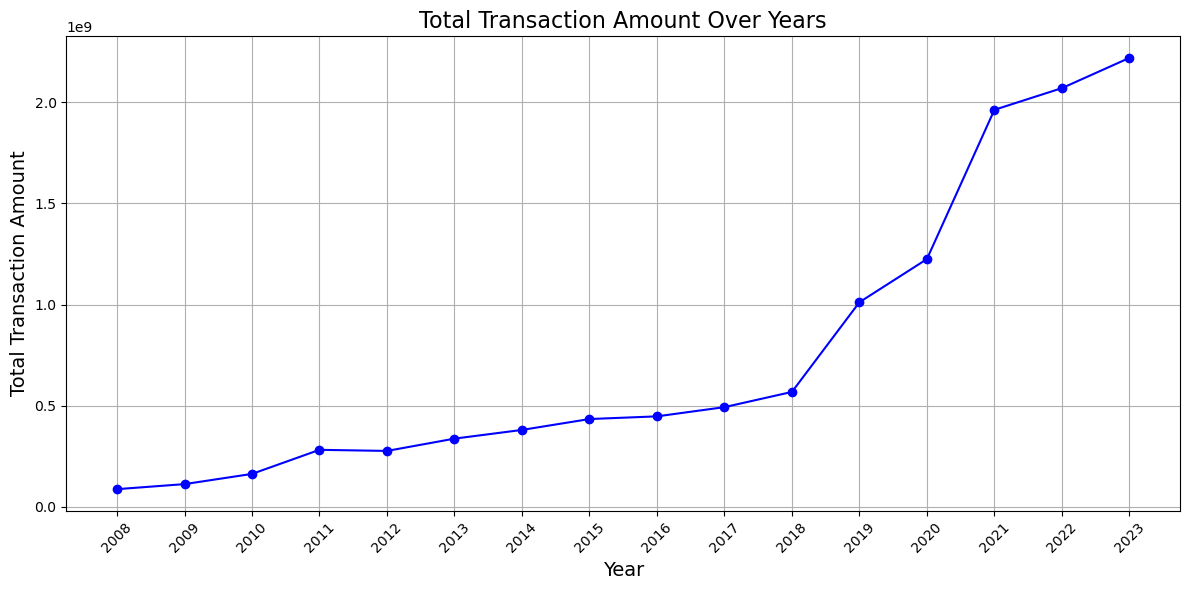

In [15]:
# Check if time_series_data is empty & summarize transaction amounts by year 
if time_series_data.empty:
    print("No data found for the time series analysis.")
else:
    # Plotting the time series with enhanced visualization
    plt.figure(figsize=(12, 6))
    plt.plot(time_series_data['year'], time_series_data['total_transaction'], marker='o', color='b')
    plt.title('Total Transaction Amount Over Years', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Total Transaction Amount', fontsize=14)
    plt.xticks(time_series_data['year'], rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [16]:
con.execute("DESCRIBE bank_data").fetchdf()

,column_name,column_type,null,key,default,extra
0,Id,BIGINT,YES,None,None,None
1,customer_id,BIGINT,YES,None,None,None
2,interest_rate,DOUBLE,YES,None,None,None
3,name,VARCHAR,YES,None,None,None
4,country,VARCHAR,YES,None,None,None
5,date_of_birth,DATE,YES,None,None,None
6,address,VARCHAR,YES,None,None,None
7,date,TIMESTAMP_NS,YES,None,None,None
8,atm_transfer_in,BIGINT,YES,None,None,None
9,atm_transfer_out,BIGINT,YES,None,None,None


# **Step 3: Feature Engineering**

In [17]:
import dask.dataframe as dd
import pandas as pd

# Load and inspect your data
# Assuming `dask_df` is already loaded

# Convert 'date' to datetime
train_dask_df['date'] = dd.to_datetime(train_dask_df['date'])
test_dask_df['date'] = dd.to_datetime(test_dask_df['date'])

# Calculate recency
current_date = pd.Timestamp.now()
train_dask_df['recency'] = (current_date - train_dask_df['date']).dt.days
test_dask_df['recency'] = (current_date - train_dask_df['date']).dt.days


# Group by 'customer_id' and aggregate of train dataset
features = train_dask_df.groupby('customer_id').agg({
    'recency': 'min',  # Minimum recency
    'transaction_amount': 'mean',  # Average transaction amount
    'churn_due_to_fraud': 'max'  # Assuming this indicates churn
}).reset_index()

# Compute the result
features = features.compute()

# Preview the features
print("Train features : \n")
print(features.head())
print(f"Total count :\n {len(features)}")

Train features : 

   customer_id  recency  transaction_amount  churn_due_to_fraud
0            1      820         2995.989836               False
1            2     5331          781.254156               False
2            3     1001         2193.721653               False
3            4     5770          270.982267               False
4            5      749         1208.958094               False
Total count :
 106179


In [18]:
# Check for Duplicate Labels in the Index in test dataset
# Group by 'customer_id' and aggregate of train dataset
features_test = test_dask_df.groupby('customer_id').agg({
    'recency': 'min',  # Minimum recency
    'transaction_amount': 'mean',  # Average transaction amount
    'churn_due_to_fraud': 'max'  # Assuming this indicates churn
}).reset_index()

# Compute the result
features_test = features_test.compute()

# Preview the features
print("Train features : \n")
print(features.head())
print(f"Total count :\n {len(features_test)}")

ValueError: cannot reindex on an axis with duplicate labels

In [136]:
# Check the number of duplicate customer IDs
duplicate_customer_ids = test_dask_df['customer_id'].map_partitions(lambda df: df.duplicated().sum()).compute()
print(f"Number of duplicate customer IDs: {duplicate_customer_ids}")

# Drop duplicates based on customer_id
test_dask_df = test_dask_df.drop_duplicates(subset=['customer_id'])

# Reset index to ensure no duplicates in the index
test_dask_df = test_dask_df.reset_index(drop=True)


Number of duplicate customer IDs: 0    0
dtype: int64


# **Step 4: Data Visualization for Feature Insights**

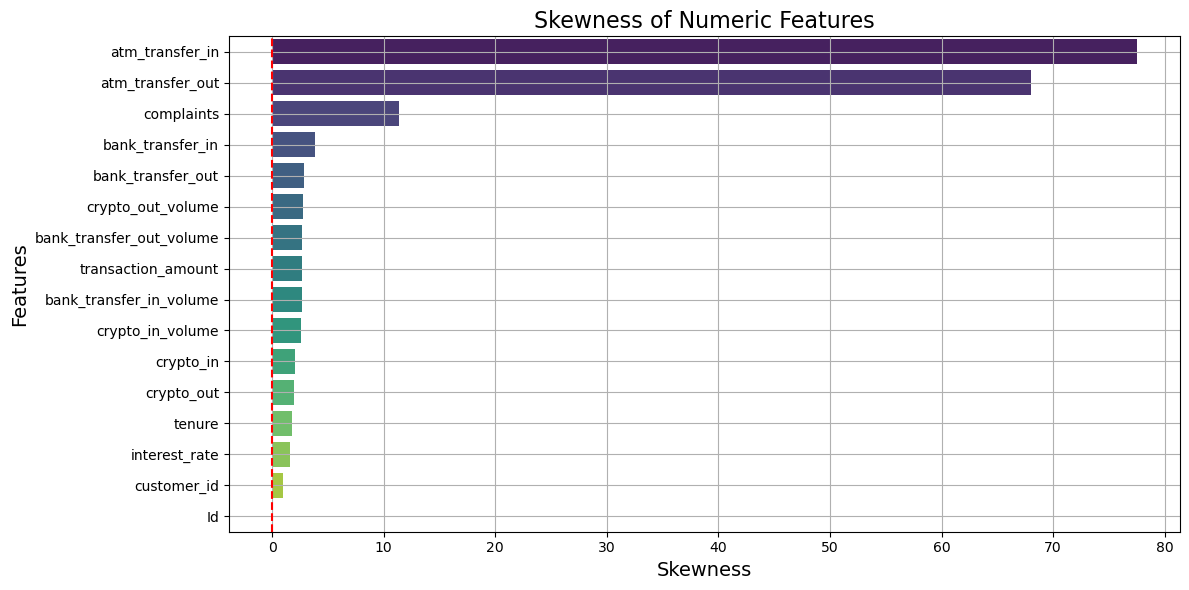

In [65]:
# Assuming you have your DataFrame named pandas_df
# Select only numeric columns
numeric_df = pandas_train_df.select_dtypes(include=['number'])

# Calculate skewness for each numeric column
skewness = numeric_df.skew().sort_values(ascending=False)

# Create a DataFrame for better visualization
skewness_df = pd.DataFrame({'Feature': skewness.index, 'Skewness': skewness.values})

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the skewness
sns.barplot(x='Skewness', y='Feature', data=skewness_df, palette='viridis')
plt.axvline(0, color='red', linestyle='--')  # Add a line at x=0 for reference
plt.title('Skewness of Numeric Features', fontsize=16)
plt.xlabel('Skewness', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

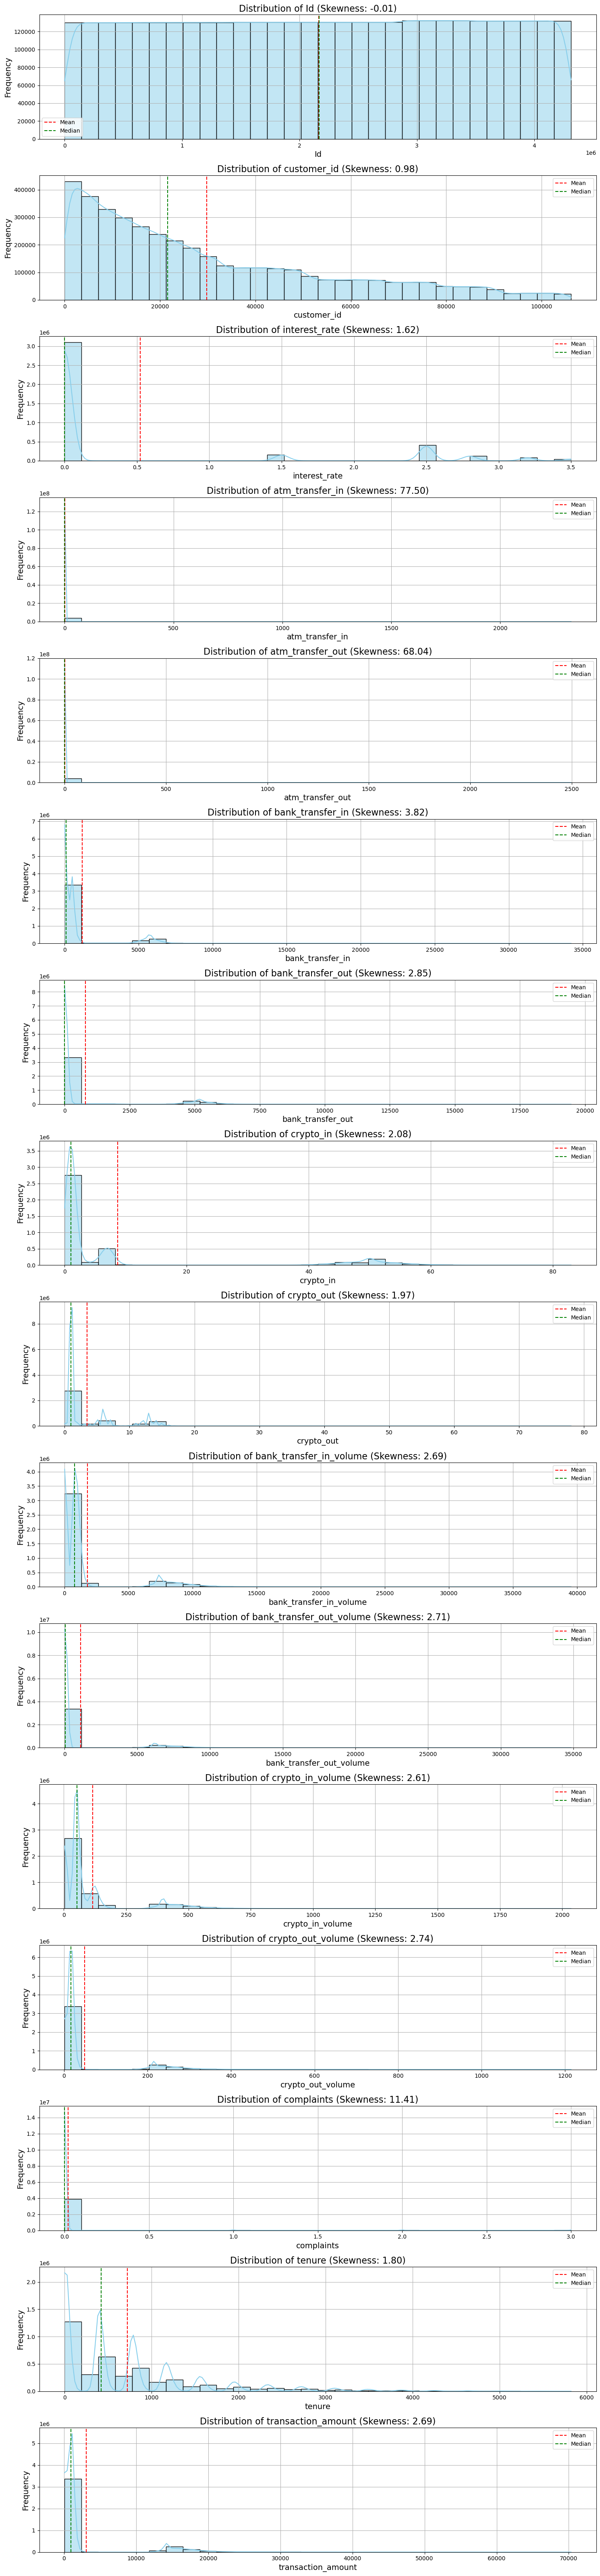

In [71]:
# Selecting only numeric columns
numeric_df = pandas_train_df.select_dtypes(include=['number'])

# Calculate skewness for each numeric column
skewness = numeric_df.skew()

# Set the figure size for the plots
plt.figure(figsize=(15, 4 * len(skewness)))

# Iterate through each numeric column and plot skewness
for i, column in enumerate(numeric_df.columns):
    plt.subplot(len(numeric_df.columns), 1, i + 1)  # Create a subplot for each feature
    sns.histplot(numeric_df[column], kde=True, color='skyblue', bins=30)
    plt.axvline(numeric_df[column].mean(), color='red', linestyle='--', label='Mean')
    plt.axvline(numeric_df[column].median(), color='green', linestyle='--', label='Median')
    plt.title(f'Distribution of {column} (Skewness: {skewness[column]:.2f})', fontsize=16)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

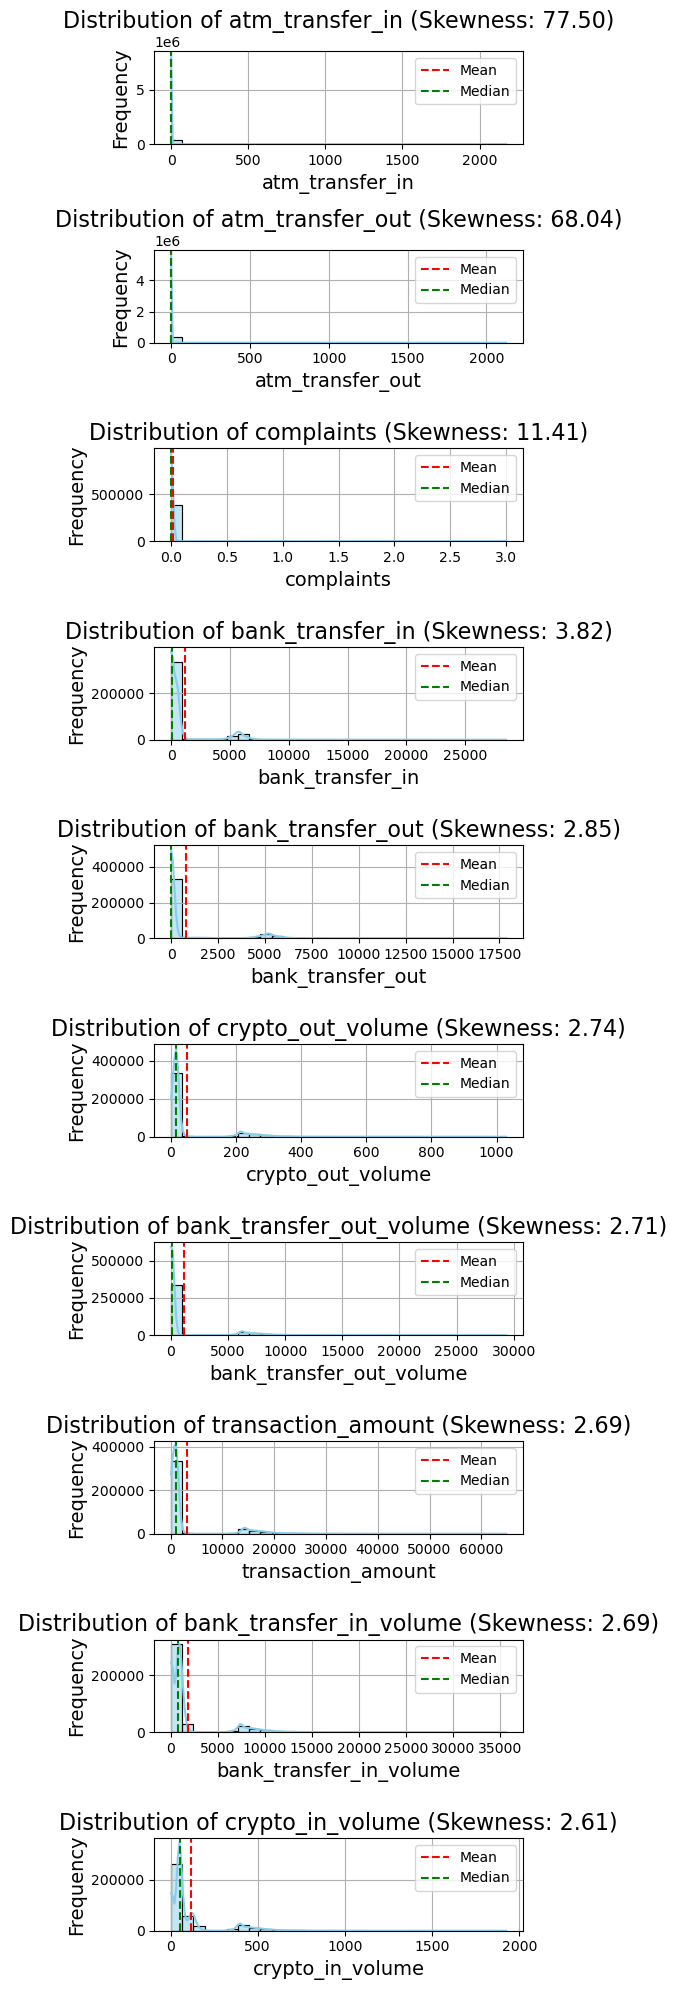

In [69]:
###  Top 10 skewed features

# Select only numeric columns
numeric_df = pandas_train_df.select_dtypes(include=['number'])

# Calculate skewness and sort by absolute skewness
skewness = numeric_df.skew()
skewness = skewness.abs().sort_values(ascending=False)

# Select the top 10 most skewed columns (or adjust this number as needed)
top_skewed_columns = skewness.head(10).index
numeric_df = numeric_df[top_skewed_columns]

# Downsample data (optional, for large datasets)
sampled_df = numeric_df.sample(frac=0.1, random_state=42)

# Set figure size
plt.figure(figsize=(5, 2 * len(numeric_df.columns)))

# Iterate through the selected columns
for i, column in enumerate(numeric_df.columns):
    plt.subplot(len(numeric_df.columns), 1, i + 1)
    sns.histplot(sampled_df[column], kde=True, color='skyblue', bins=30)
    plt.axvline(sampled_df[column].mean(), color='red', linestyle='--', label='Mean')
    plt.axvline(sampled_df[column].median(), color='green', linestyle='--', label='Median')
    plt.title(f'Distribution of {column} (Skewness: {skewness[column]:.2f})', fontsize=16)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

Index(['customer_id', 'recency', 'transaction_amount', 'churn_due_to_fraud'], dtype='object')


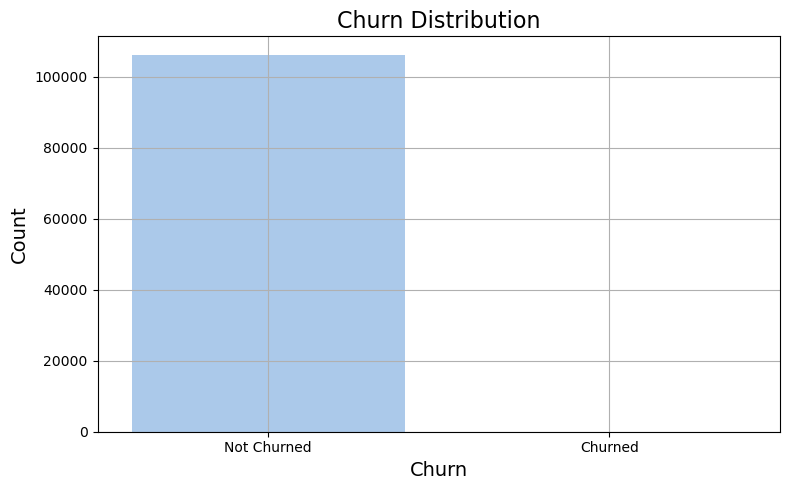

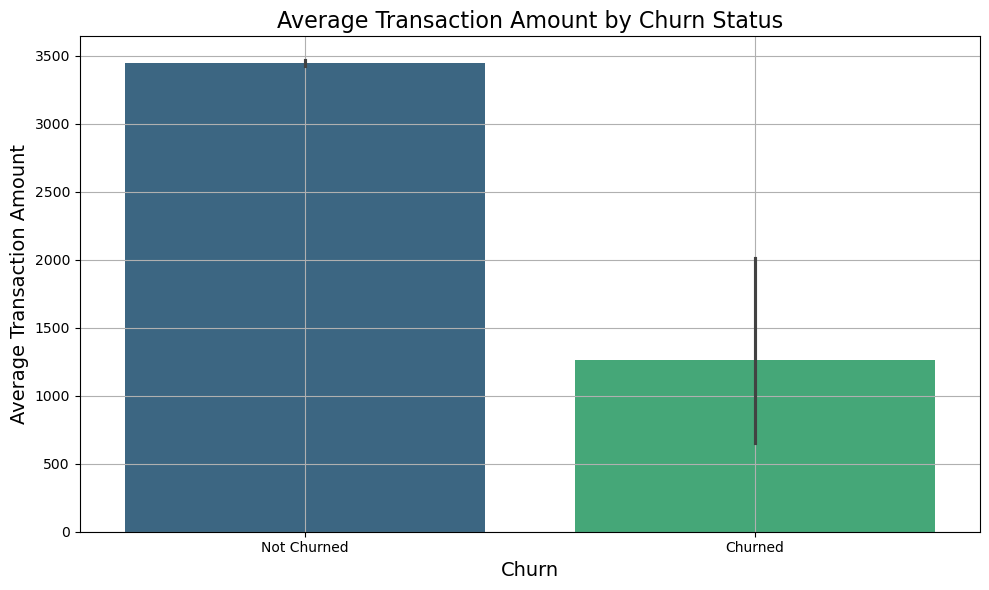

In [72]:
# Check the columns in the features DataFrame
print(features.columns)

# Visualizing the distribution of churn
plt.figure(figsize=(8, 5))
sns.countplot(data=features, x='churn_due_to_fraud', palette='pastel')
plt.title('Churn Distribution', fontsize=16)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['Not Churned', 'Churned'], rotation=0)
plt.grid()
plt.tight_layout()
plt.show()

# Visualizing the average transaction amount by churn status
plt.figure(figsize=(10, 6))
sns.barplot(data=features, x='churn_due_to_fraud', y='transaction_amount', palette='viridis')
plt.title('Average Transaction Amount by Churn Status', fontsize=16)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Average Transaction Amount', fontsize=14)
plt.xticks([0, 1], ['Not Churned', 'Churned'], rotation=0)
plt.grid()
plt.tight_layout()
plt.show()

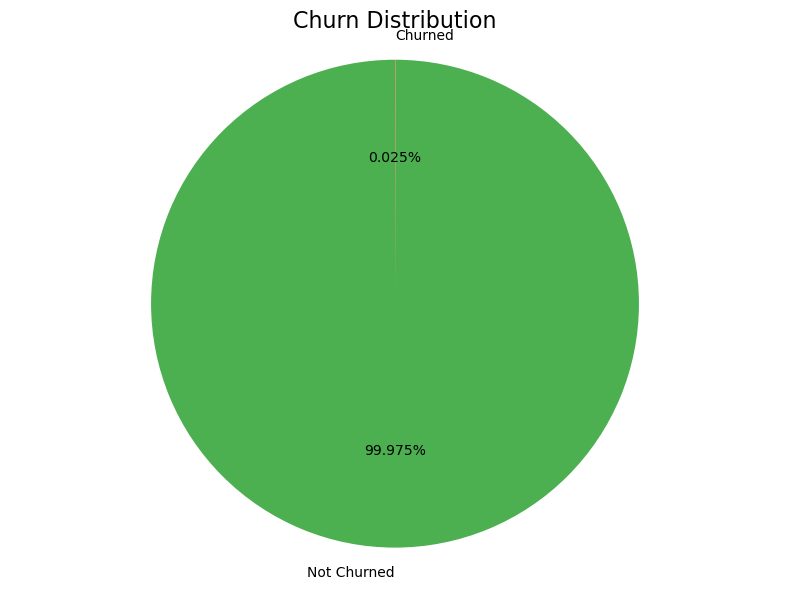

In [73]:
# Pie chart for churn distribution
plt.figure(figsize=(8, 6))
churn_counts = features['churn_due_to_fraud'].value_counts()
plt.pie(churn_counts, labels=['Not Churned', 'Churned'], autopct='%1.3f%%', startangle=90, colors=['#4CAF50', '#FF5722'])
plt.title('Churn Distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular
plt.tight_layout()
plt.show()

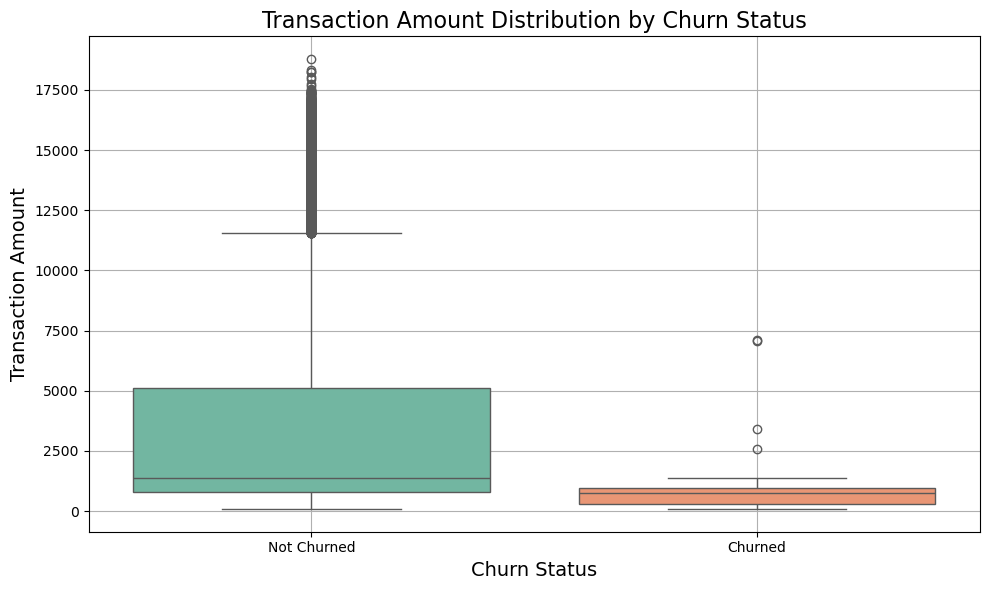

In [74]:
# Box plot for transaction amount by churn status
plt.figure(figsize=(10, 6))
sns.boxplot(data=features, x='churn_due_to_fraud', y='transaction_amount', palette='Set2')
plt.title('Transaction Amount Distribution by Churn Status', fontsize=16)
plt.xlabel('Churn Status', fontsize=14)
plt.ylabel('Transaction Amount', fontsize=14)
plt.xticks([0, 1], ['Not Churned', 'Churned'], rotation=0)
plt.grid()
plt.tight_layout()
plt.show()

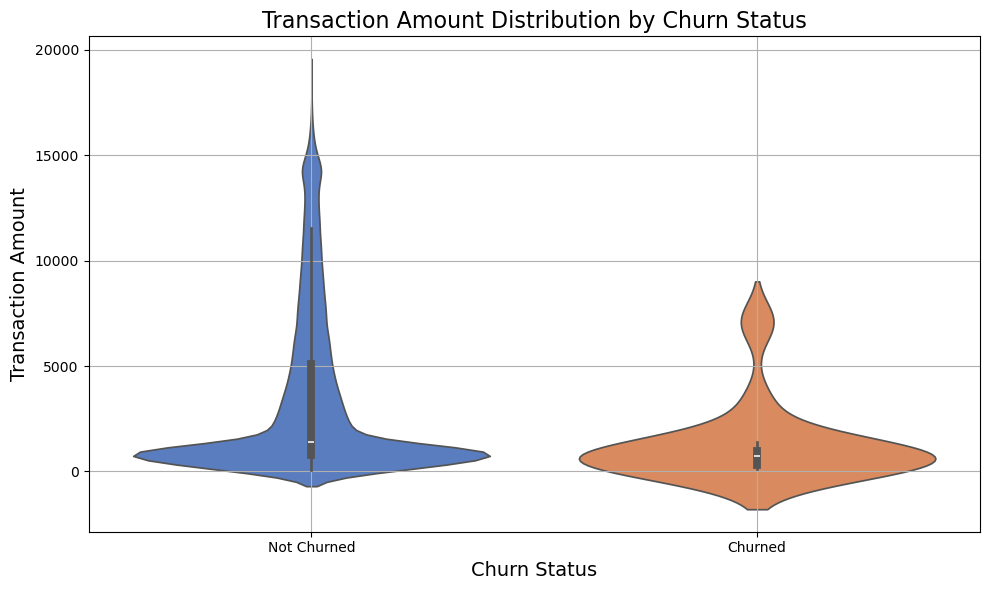

In [75]:
# Violin plot for transaction amount by churn status
plt.figure(figsize=(10, 6))
sns.violinplot(data=features, x='churn_due_to_fraud', y='transaction_amount', palette='muted')
plt.title('Transaction Amount Distribution by Churn Status', fontsize=16)
plt.xlabel('Churn Status', fontsize=14)
plt.ylabel('Transaction Amount', fontsize=14)
plt.xticks([0, 1], ['Not Churned', 'Churned'], rotation=0)
plt.grid()
plt.tight_layout()
plt.show()

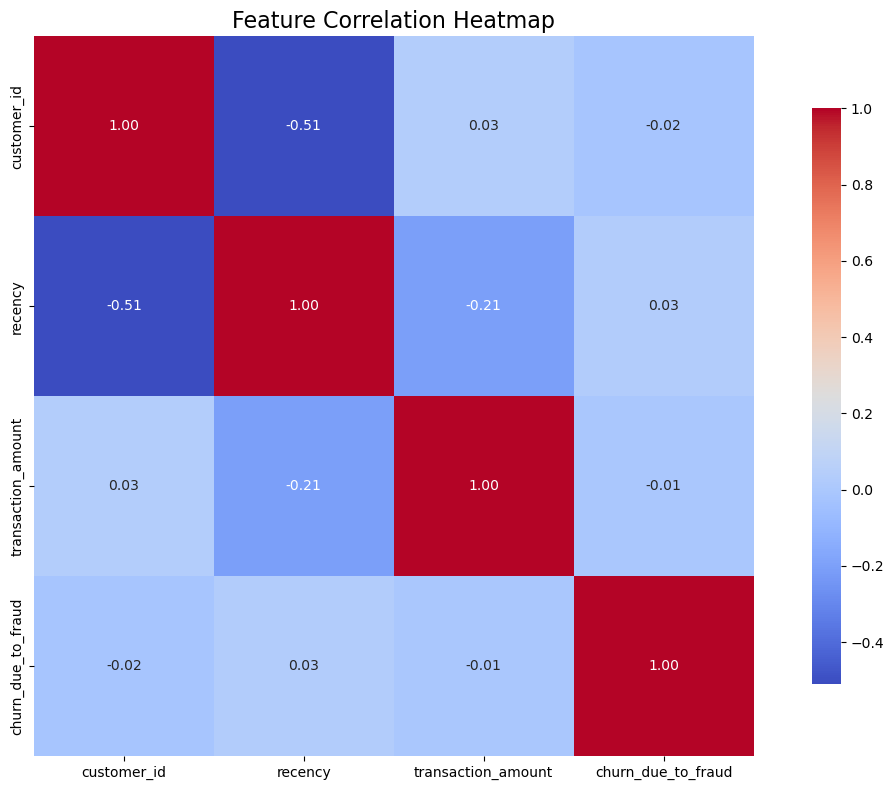

In [76]:
# Heatmap for correlation matrix
plt.figure(figsize=(12, 8))
correlation = features.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

# **Step 5: Prepare Data for Model Training**

In [78]:
# Check the columns in the features DataFrame to find the correct churn column name
print("Features DataFrame Columns:", features.columns.tolist())

# Prepare features for modeling
# Replace 'churn' with the correct column name if it's different
X_train = features.drop(['customer_id', 'churn_due_to_fraud'], axis=1)  # Adjust 'churn_due_to_fraud' if needed
y_train = features['churn_due_to_fraud']  # Adjust 'churn_due_to_fraud' if needed

# Display the shape of training and testing sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

Features DataFrame Columns: ['customer_id', 'recency', 'transaction_amount', 'churn_due_to_fraud']
X_train shape: (106179, 2)
y_train shape: (106179,)


# **Step 6: Train the XGBoost Model**